### A linear ODE

$$ u''(t) + c^2 u(t) = 0, \;\; u(t_0)=u_0 $$ 
has analytical solution 
$$u(t) = u_0 \cos{(ct)}.$$

In [289]:
import numpy as np
import scipy

In [290]:
class ODESolver:

    def __init__(self, f) -> None:
        # Wrap user’s f in a new function that always
        # converts list/tuple to array (or let array be array)

        self.f = lambda t, u: np.asarray(f(t,u), float)

    def set_initial_condition(self, u0):

        if isinstance(u0, (float, int)):     # if scalar ODE
            self.neq = 1                     # num of equations
            u0 = float(u0)
        else:
            u0 = np.asarray(u0)
            self.neq = u0.size

        self.u0 = u0

    def solve(self, t_span, N):
        """Compute solution for t_span[0] <= t <= t_span[1], using N steps."""

        t0, T = t_span
        self.dt = T / N
        self.t = np.zeros(N+1)              #N steps ~ N+1 time points
        if self.neq == 1:
            self.u = np.zeros(N+1)
        else:
            self.u = np.zeros((N+1, self.neq))

        self.t[0] = t0
        self.u[0] = self.u0

        for n in range(N):
            self.n = n
            self.t[n+1] = self.t[n] + self.dt
            self.u[n+1] = self.advance()
    
        return self.t, self.u


In [291]:
class ForwardEuler(ODESolver):


    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        unew = u[n] + dt*f(t[n], u[n])
        return unew


class ExplicitMidpoint(ODESolver):


    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        dt2 = dt/2.0
        k1 = f(t[n], u[n])
        k2 = f(t[n] + dt2, u[n] + dt2*k1)
        unew = u[n] + dt*k2
        return unew


class RungeKutta4(ODESolver):


    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        dt2 = dt/2.0
        k1 = f(t[n], u[n],)
        k2 = f(t[n] + dt2, u[n] + dt2*k1, )
        k3 = f(t[n] + dt2, u[n] + dt2*k2, )
        k4 = f(t[n] + dt, u[n] + dt*k3, )
        unew = u[n] + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        return unew


class BDF1(ODESolver):


    def stage_eq(self, k):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        return k - f(t[n]+dt, u[n]+dt*k)
    

    def solve_stage(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        k0 = f(t[n], u[n])
        sol = scipy.optimize.root(self.stage_eq, k0)
        return sol.x
    

    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        k1 = self.solve_stage()
        return u[n]+dt*k1


class CrankNicolson(BDF1):

    
    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        k1 = f(t[n],u[n])
        k2 = self.solve_stage()
        return u[n]+dt/2*(k1+k2)

In [292]:
def RMSE(y_pred, y_calc):
    return np.sqrt(np.linalg.norm(y_pred - y_calc))

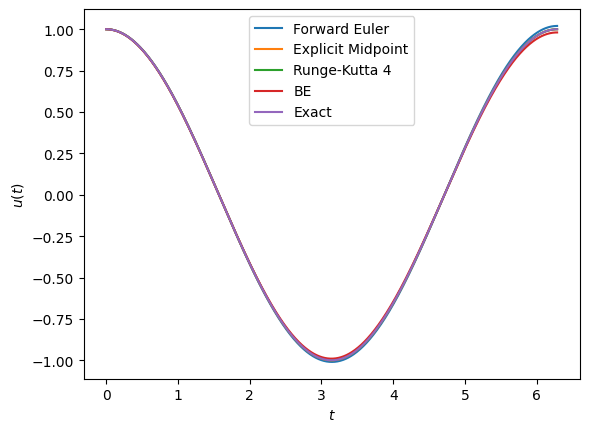

[FE]:  0.5116182915339018
[EM]:  0.022893029300172077
[RK4]: 3.2166218747238954e-05
[BE]:  0.5081924282819101


In [293]:
import matplotlib.pyplot as plt


def f(t, u):
    return np.array([-u[1], u[0]])


t_span = (0, 2*np.pi)   # t_span == [a, b]
N = 1000
fe = ForwardEuler(f)
fe.set_initial_condition(u0=(1, 0))
t1, u1 = fe.solve(t_span, N)
plt.plot(t1, u1[:, 0], label='Forward Euler')

em = ExplicitMidpoint(f)
em.set_initial_condition(u0=(1, 0))
t2, u2 = em.solve(t_span, N)
plt.plot(t2, u2[:, 0], label='Explicit Midpoint')
         
rk4 = RungeKutta4(f)
rk4.set_initial_condition(u0=(1, 0))
t3, u3 = rk4.solve(t_span, N)
plt.plot(t3, u3[:, 0], label='Runge-Kutta 4')

be = BDF1(f)
be.set_initial_condition(u0=(1, 0))
t4, u4 = be.solve(t_span, N)
plt.plot(t4, u4[:, 0], label='BE')


time_exact = np.linspace(0, 2*np.pi, 1001)
exact = np.cos(time_exact)
plt.plot(time_exact, exact, label='Exact')


plt.xlabel('$t$')
plt.ylabel('$u(t)$')
plt.legend()
plt.show()

print(f'[FE]:  {RMSE(u1[:, 0], exact)}')
print(f'[EM]:  {RMSE(u2[:, 0], exact)}')
print(f'[RK4]: {RMSE(u3[:, 0], exact)}')
print(f'[BE]:  {RMSE(u4[:, 0], exact)}')
